In [1]:
import sys
import numpy as np
import xarray as xr
import cmaps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
ccmap = cmaps.ncl_default
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point
ccmap1 = cmaps.NEO_div_vegetation_a
plt.rcParams['font.family'] = 'Helvetica'

# 定义函数

In [2]:
def calculate_consistency_2d(model_trends, ensemble_trend):
    num_models = model_trends.shape[0]
    consistency_mask = np.full(ensemble_trend.shape, False)
    for i in range(ensemble_trend.shape[0]):
        for j in range(ensemble_trend.shape[1]):
            # 计算与集合平均趋势符号一致的模式数量
            num_consistent_models = np.sum(np.sign(model_trends[:, i, j]) == np.sign(ensemble_trend[i, j]))
            # 判断是否超过80%
            if num_consistent_models / num_models >= 0.8:
                consistency_mask[i, j] = True
    return consistency_mask

def plot_meri_section(ax1, lat,level,level_label,
                      meri_data,meri_data_levels,ccmap,meri_clim,meri_clim_levels,mme_consistency,set_xticks,
                      left_title,colorbar_label,color_bar_ticks,sequence):

    cycle_data, cycle_lat = add_cyclic_point(meri_data, coord=lat)
    cycle_lat, cycle_level = np.meshgrid(cycle_lat, np.arange(level.shape[0]))
    #cycle_MON = cycle_MON.filled(np.nan)
    cycle_data = cycle_data.filled(np.nan)

    c1 = ax1.contourf(cycle_lat, cycle_level, cycle_data, cmap=ccmap, levels=meri_data_levels, extend='both')
    cycle_clim, cycle_mon = add_cyclic_point(meri_clim, coord=lat)
    c2 = ax1.contour(cycle_lat, cycle_level, cycle_clim, levels=meri_clim_levels, colors='k', alpha=0.6,
                         linewidths=.5)
    ax1.clabel(c2, inline=True, fontsize=6)

    # 绘制一致性阴影
    if mme_consistency is not None:
        cycle_dot, cycle_mon = add_cyclic_point(mme_consistency, coord=lat)
        significance = np.ma.masked_where(cycle_dot == False, cycle_dot)
        c3 = ax1.contourf(cycle_lat, cycle_level, significance, colors='none', hatches=['////'])

        if hasattr(c3, 'collections'):
            collections = c3.collections
        else:
            collections = [c3]
        # 设置 hatch 样式
        for collection in collections:
            collection.set_edgecolor('grey')
            collection.set_linewidth(0)

    ax1.set_xticks(set_xticks)  # 指定要显示的经纬度
    ax1.xaxis.set_major_formatter(LatitudeFormatter())  # 刻度格式转换为经纬度样式
    ax1.yaxis.set_ticks(np.arange(level.shape[0]), level_label)  # 指定要显示的经纬度
    ax1.tick_params(axis='x', labelsize=7)  # 设置x轴刻度数字大小
    ax1.tick_params(axis='y', labelsize=7)  # 设置y轴刻度数字大小
    ax1.text(-0.15, 1.15, sequence, transform=ax1.transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    ax1.set_title(left_title, loc='left', fontsize=7)
    ax1.set_title('SSP585-HIST', loc='right', fontsize=7)
    if sequence == 'A':
        ax1.set_ylabel('Level (hPa)', fontsize=7)

    '''cb = fig.colorbar(c1, orientation='vertical', shrink=0.75, fraction=0.1,pad=0.05, extend='both')
    cb.ax.yaxis.set_major_locator(MultipleLocator(0.2))
    #cb.ax.set_size([0.5,0.2])
    cb.set_ticks(color_bar_ticks)
    cb.ax.tick_params(axis='y',which='major', direction='in', length=6, labelsize=6)
        # cb.ax.tick_params(which='minor', direction='in', length=5)
    cb.set_label(label=colorbar_label, fontsize=8)
    cb.ax.tick_params(labelsize=8)'''
    return c1


# 读取处理数据

In [3]:
models = ["BCC-CSM2-MR", "CanESM5", "CESM2-WACCM","FGOALS-g3","GFDL-CM4",
          "IPSL-CM6A-LR", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR",
          "NorESM2-MM", "KACE-1-0-G","MIROC6",
          "NorESM2-LM","INM-CM4-8","INM-CM5-0","TaiESM1","MRI-ESM2-0"]#2025.9.15发现文件缺少"IITM-ESM"
Q=0.95
##########计算TI1 VWS DEF垂向剖面
TI_level_zonmean_change_list=[]
TI_level_zonmean_hist_list=[]
VWS_level_zonmean_change_list=[]
VWS_level_zonmean_hist_list=[]
DEF_level_zonmean_change_list=[]
DEF_level_zonmean_hist_list=[]
IN_DIR = "/home/dongyl/Work2024/Tl/saved_npy/model_turbulence_data/new_DEF_TI1"
for model in models:
    file1 = f"{IN_DIR}/TI1/TI1_95p_freq/TI1_{model}_historical_1980-2010_exceed_pct_{int(Q * 100)}p.nc"
    file2 = f"{IN_DIR}/TI1/TI1_95p_freq/TI1_{model}_ssp585_2060-2090_exceed_pct_{int(Q * 100)}p.nc"
    file3 = f"{IN_DIR}/VWS/VWS_95p_freq/VWS_{model}_historical_1980-2010_exceed_pct_{int(Q*100)}p.nc"
    file4 = f"{IN_DIR}/VWS/VWS_95p_freq/VWS_{model}_ssp585_2060-2090_exceed_pct_{int(Q*100)}p.nc"
    file5 = f"{IN_DIR}/DEF/DEF_95p_freq/DEF_{model}_historical_1980-2010_exceed_pct_{int(Q*100)}p.nc"
    file6 = f"{IN_DIR}/DEF/DEF_95p_freq/DEF_{model}_ssp585_2060-2090_exceed_pct_{int(Q*100)}p.nc"

    TI_level_array_hist= xr.open_dataset(file1)["frequency"].sel(lat=slice(10, 60))
    TI_level_array_future= xr.open_dataset(file2)["frequency"].sel(lat=slice(10, 60))
    VWS_level_array_hist = xr.open_dataset(file3)["frequency"].sel(lat=slice(10, 60))
    VWS_level_array_future = xr.open_dataset(file4)["frequency"].sel(lat=slice(10, 60))
    DEF_level_array_hist = xr.open_dataset(file5)["frequency"].sel(lat=slice(10, 60))
    DEF_level_array_future = xr.open_dataset(file6)["frequency"].sel(lat=slice(10, 60))
    print(TI_level_array_hist.shape)

    TI_level_zonmean_hist = np.nanmean(TI_level_array_hist,axis=-1)
    print(TI_level_zonmean_hist.shape)
    TI_level_zonmean_future = np.nanmean(TI_level_array_future,axis=-1)
    TI_level_zonmean_change = TI_level_zonmean_future - TI_level_zonmean_hist
    TI_level_zonmean_change_list.append(TI_level_zonmean_change)
    TI_level_zonmean_hist_list.append(TI_level_zonmean_hist)

    VWS_level_zonmean_hist = np.nanmean(VWS_level_array_hist, axis=-1)
    VWS_level_zonmean_future = np.nanmean(VWS_level_array_future, axis=-1)
    VWS_level_zonmean_change = VWS_level_zonmean_future - VWS_level_zonmean_hist
    VWS_level_zonmean_change_list.append(VWS_level_zonmean_change)
    VWS_level_zonmean_hist_list.append(VWS_level_zonmean_hist)

    DEF_level_zonmean_hist = np.nanmean(DEF_level_array_hist,axis=-1)
    DEF_level_zonmean_future = np.nanmean(DEF_level_array_future,axis=-1)
    DEF_level_zonmean_change = DEF_level_zonmean_future - DEF_level_zonmean_hist
    DEF_level_zonmean_change_list.append(DEF_level_zonmean_change)
    DEF_level_zonmean_hist_list.append(DEF_level_zonmean_hist)

hist_TI_NH_mme = np.nanmean(np.stack(TI_level_zonmean_hist_list), axis=0)
change_TI_NH_mme = np.nanmean(np.stack(TI_level_zonmean_change_list), axis=0)
hist_VWS_NH_mme = np.nanmean(np.stack(VWS_level_zonmean_hist_list), axis=0)
change_VWS_NH_mme = np.nanmean(np.stack(VWS_level_zonmean_change_list), axis=0)
hist_DEF_NH_mme = np.nanmean(np.stack(DEF_level_zonmean_hist_list), axis=0)
change_DEF_NH_mme = np.nanmean(np.stack(DEF_level_zonmean_change_list), axis=0)

TI_NH_mme_consistency = calculate_consistency_2d(np.stack(TI_level_zonmean_change_list),change_TI_NH_mme)
VWS_NH_mme_consistency = calculate_consistency_2d(np.stack(VWS_level_zonmean_change_list),change_VWS_NH_mme)
DEF_NH_mme_consistency = calculate_consistency_2d(np.stack(DEF_level_zonmean_change_list),change_DEF_NH_mme)


(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)
(8, 41, 289)
(8, 41)


In [4]:
##########计算纬向风垂向剖面
models = ["BCC-CSM2-MR", "CanESM5", "CESM2-WACCM","FGOALS-g3","GFDL-CM4",
          "IPSL-CM6A-LR", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR",
          "NorESM2-MM", "KACE-1-0-G","MIROC6",
          "NorESM2-LM","INM-CM4-8","INM-CM5-0","TaiESM1","MRI-ESM2-0"]#2025.9.15发现文件缺少"IITM-ESM"

'''hist_ua_NH=[]
future_u_NH=[]
change_u_NH=[]
for model in models:
    file_u_hist_path = f'/home/share-to-3/dongyl/cmip_day/interpolated_remapbiled_289x145/N_hemisphere/ua_historical_{model}_day_interpolated_289x145_N.nc'
    file_u_ssp_path = f'/home/share-to-3/dongyl/cmip_day/interpolated_remapbiled_289x145/N_hemisphere/ua_ssp585_{model}_day_interpolated_289x145_N.nc'
    print(xr.open_dataset(file_u_hist_path))
    interp_u_hist = xr.open_dataset(file_u_hist_path)["ua_interp"]
    interp_u_future = xr.open_dataset(file_u_ssp_path)["ua_interp"]
    hist_ua_NH_model = np.nanmean(np.nanmean(interp_u_hist,axis=0),axis=-1)
    future_ua_NH_model = np.nanmean(np.nanmean(interp_u_future,axis=0),axis=-1)
    #hist_ua_NH.append(hist_ua_NH_model)
    change_u_NH.append(future_ua_NH_model-hist_ua_NH_model)

change_ua_NH = np.stack(change_u_NH)'''

level_label2=['1000', '925', '850', '700', '500','300','250','200','150','100','50', '10']
#hist_ua_NH_mme = np.nanmean(np.stack(hist_ua_NH), axis=0)
hist_ua_NH_mme = np.load('/home/dongyl/Work2024/Tl/saved_npy/hist_ua_NH_mme_interpolated.npy')
#change_ua_NH_mme = np.nanmean(np.stack(change_ua_NH), axis=0)
change_ua_NH_mme = np.load('/home/dongyl/Work2024/Tl/saved_npy/change_ua_NH_mme_interpolated.npy')

ua_NH_mme_consistency=np.load('/home/dongyl/Work2024/Tl/saved_npy/ua_NH_mme_consistency.npy')
#ua_NH_mme_consistency= calculate_consistency_2d(np.stack(change_ua_NH),change_ua_NH_mme)
#np.save('/home/dongyl/Work2024/Tl/saved_npy/obs_npy/ua_NH_mme_consistency.npy',ua_NH_mme_consistency)

file_path2 = f'/home/share-to-3/dongyl/cmip_day/interpolated_remapbiled_289x145/N_hemisphere/ua_ssp585_{model}_day_interpolated_289x145_N.nc'
lat2 = xr.open_dataset(file_path2).lat.values
lon2 = xr.open_dataset(file_path2).lon.values
print('ok')
level2 = xr.open_dataset(file_path2).plev

ok


In [5]:
#np.save('/home/dongyl/Work2024/Tl/saved_npy/ua_NH_mme_consistency.npy',ua_NH_mme_consistency)
#np.save('/home/dongyl/Work2024/Tl/saved_npy/change_ua_NH.npy',change_ua_NH)

# 开始绘制图像

ok
<xarray.DataArray 'plev' (plev: 6)> Size: 48B
array([ 5,  6,  7,  8,  9, 10])
Dimensions without coordinates: plev
(8, 41)
[[ 0.7956846   0.9366849   1.1180881   1.35902     1.7090384   2.112365
   2.673738    3.3094199   4.0378056   4.978509    5.8096023   7.004099
   8.2325      9.518884   10.415252   11.33301    11.580488   11.384091
  10.728045    9.705098    8.621292    7.2597365   6.141667    5.1204925
   4.405249    3.8452828   3.3589334   3.0064127   2.628715    2.3400898
   2.0799932   1.8201869   1.5388036   1.3386085   1.1047548   0.9479897
   0.815106    0.6862188   0.59242356  0.49013227  0.42624065]
 [ 0.7952947   0.9363198   1.117769    1.3587563   1.7087917   2.1121776
   2.6735888   3.3092978   4.0378594   4.9785547   5.8097816   7.0042953
   8.232869    9.519235   10.415718   11.333444   11.580862   11.384407
  10.728341    9.7053585   8.621483    7.2598186   6.141701    5.1204543
   4.405205    3.845197    3.358792    3.0062923   2.6285372   2.3398242
   2.079762 

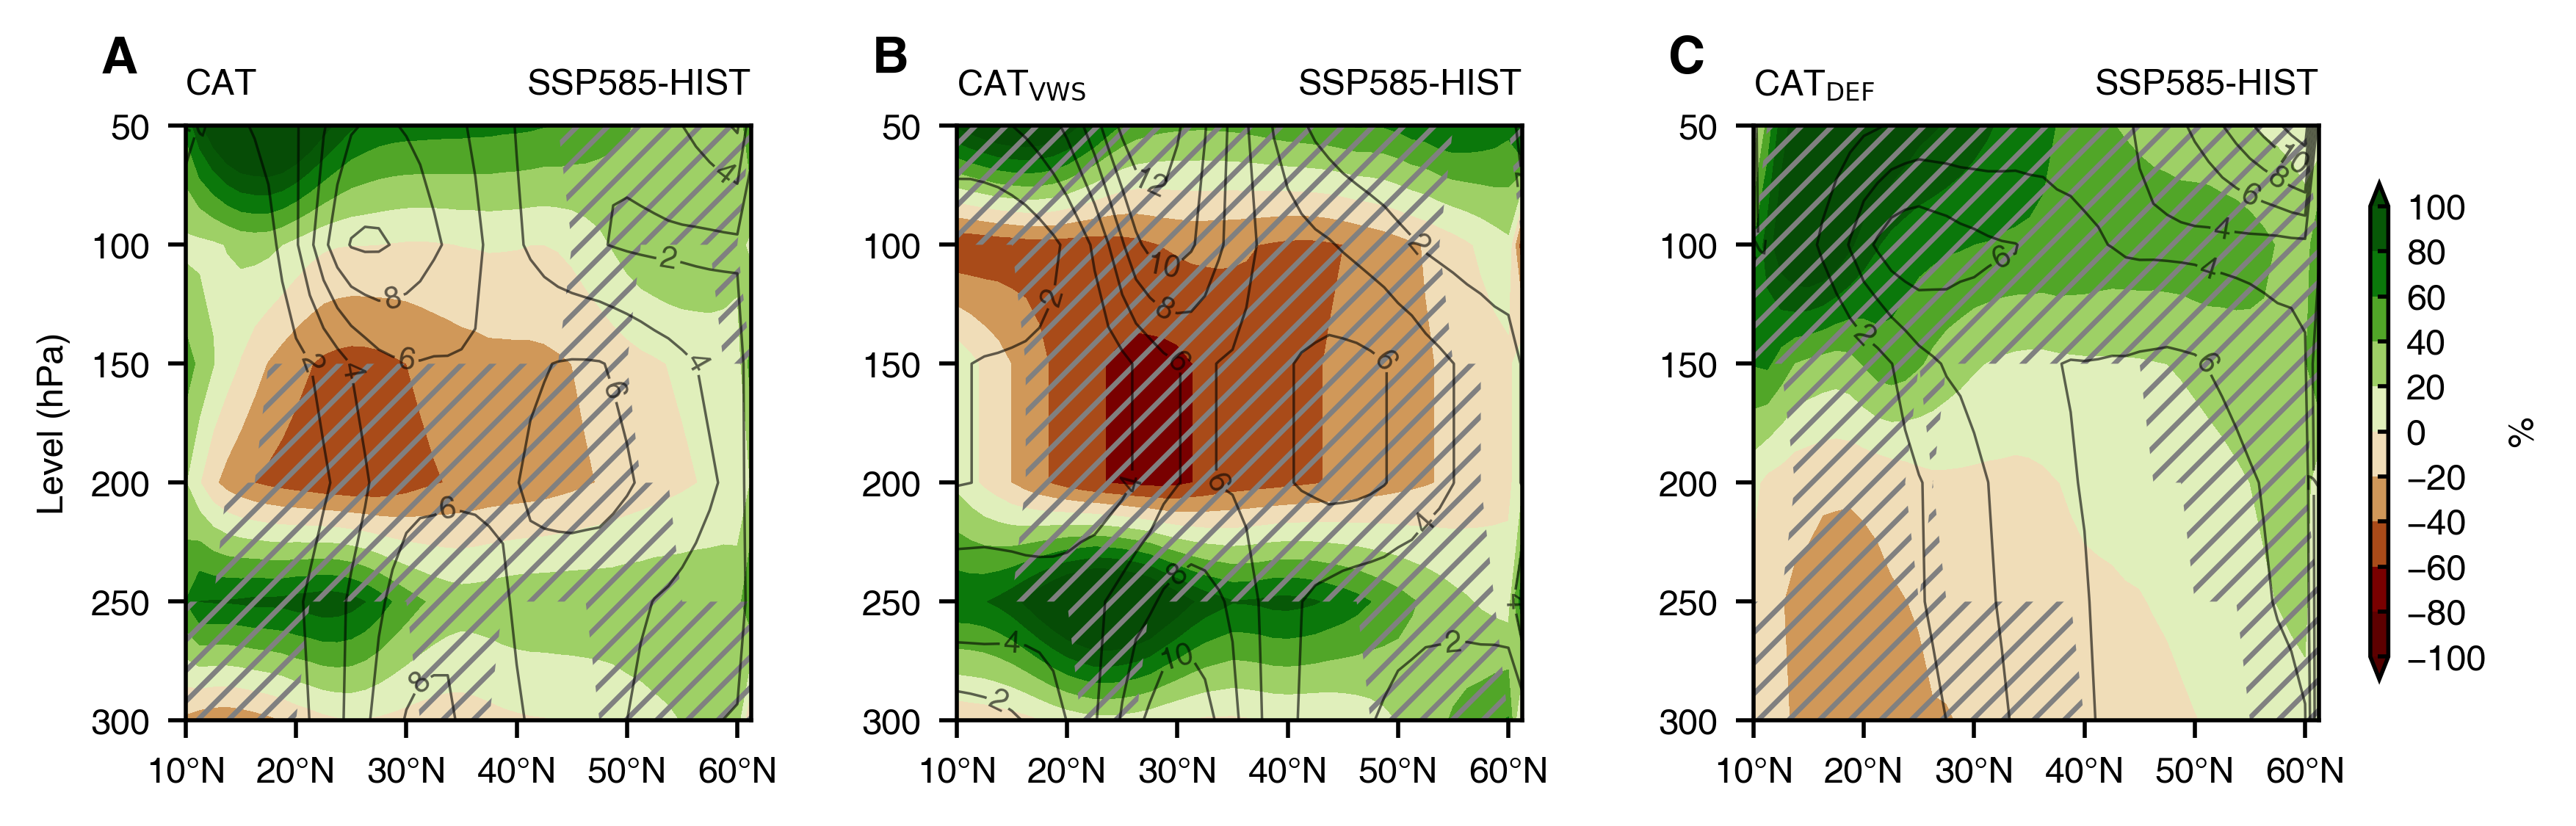

In [6]:
fig = plt.figure(figsize=(7, 2.25), dpi=500)
axes = [[0.08, 0.1, 0.22, 0.72], [0.38, 0.1, 0.22, 0.72],[0.69, 0.1, 0.22, 0.72]]

file_path1 = f'/home/share-to-3/dongyl/cmip_day/interpolated_remapbiled_289x145/N_hemisphere/ua_ssp585_{model}_day_interpolated_289x145_N.nc'
lat = xr.open_dataset(file_path1).lat.values
lat_indices = np.where((lat >= 10) & (lat <= 60))[0]
lat = xr.open_dataset(file_path1).lat[lat_indices].values
lon = xr.open_dataset(file_path1).lon.values
print('ok')
level = xr.open_dataset(file_path1).plev[5:11]
print(level)
level_label=['500','300','250','200','150','100','50', '10']
level_label=['300','250','200','150','100','50']
abschange_level = np.linspace(-8,8, 17)
relachange_level = np.linspace(-100, 100, 11)
plot_meri_section(fig.add_axes(axes[0]), lat,level,level_label,(change_TI_NH_mme[1:7]/hist_TI_NH_mme[1:7])*100,
                  relachange_level,ccmap1,hist_TI_NH_mme[1:7],
                   np.arange(0, 13, 2),TI_NH_mme_consistency[1:7],np.arange(10,61,10),
                      'CAT','%',relachange_level,'A')
plot_meri_section(fig.add_axes(axes[1]), lat,level,level_label,(change_VWS_NH_mme[1:7]/hist_VWS_NH_mme[1:7])*100,
                  relachange_level,ccmap1,hist_VWS_NH_mme[1:7],
                   np.arange(0, 13, 2),VWS_NH_mme_consistency[1:7],np.arange(10,61,10),
                      r'CAT$_\text{VWS}$','%',relachange_level,'B')
cf = plot_meri_section(fig.add_axes(axes[2]), lat,level,level_label,(change_DEF_NH_mme[1:7]/hist_DEF_NH_mme[1:7])*100,
                       relachange_level,ccmap1,hist_DEF_NH_mme[1:7],
                   np.arange(0, 13, 2),DEF_NH_mme_consistency[1:7],np.arange(10,61,10),
                      r'CAT$_\text{DEF}$','%',relachange_level,'C')
'''plot_meri_section(fig.add_axes(axes[0]), lat,level,level_label,change_TI_NH_mme[1:7],
                  abschange_level,ccmap1,hist_TI_NH_mme[1:7],
                   np.arange(0, 13, 2),TI_NH_mme_consistency[1:7],np.arange(10,61,10),
                      'TI1','%',abschange_level,'a')
plot_meri_section(fig.add_axes(axes[1]), lat,level,level_label,change_VWS_NH_mme[1:7],
                  abschange_level,ccmap1,hist_VWS_NH_mme[1:7],
                   np.arange(0, 13, 2),VWS_NH_mme_consistency[1:7],np.arange(10,61,10),
                      'VWS','%',abschange_level,'b')
cf = plot_meri_section(fig.add_axes(axes[2]), lat,level,level_label,change_DEF_NH_mme[1:7],
                       abschange_level,ccmap1,hist_DEF_NH_mme[1:7],
                   np.arange(0, 13, 2),DEF_NH_mme_consistency[1:7],np.arange(10,61,10),
                      'DEF','%',abschange_level,'c')'''
print(change_VWS_NH_mme.shape)
print(hist_VWS_NH_mme)
print(change_VWS_NH_mme/hist_VWS_NH_mme)
cbar_ax = fig.add_axes([0.93, 0.15, 0.007, 0.6])  # 调整这些数字以改变colorbar的大小和位置
cb = plt.colorbar(cf,cax=cbar_ax , orientation='vertical', shrink=0.85, pad=0.03, extend='both')
cb.ax.yaxis.set_major_locator(MultipleLocator(0.2))
cb.set_ticks(np.linspace(-100, 100, 11))
# ax1.tick_params(axis='y', labelsize=8)  # 设置y轴刻度数字大小
cb.ax.tick_params(axis='y', which='major', direction='in', length=2, labelsize=7)
# cb.ax.tick_params(which='minor', direction='in', length=5)
cb.set_label(label='%', fontsize=7)

plt.savefig(f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.S6.TI1_VWS_DEF_relachange_meri_section_95p.png', format='png',dpi=300)
plt.savefig(f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.S6.TI1_VWS_DEF_relachange_meri_section_95p.svg', format='svg',dpi=300)
plt.show()